# Calcification Detection In Mammograms

This is the official demo of the *SPIE 2021* paper: [Segmenting Microcalcifications in Mammograms and its Applications](https://arxiv.org/abs/2102.00811)

**Before we start**, to speed-up the computation time follow the following instructions:


1.   Go to *Runtime* In the top menu
2.   Choose *Change runtime type*
3.   Set *GPU* as *Hardware accelerator*
4.   Press Save


## Dowload code files

In [1]:
!git clone https://github.com/DupuisTelio/Breath_Calcification_Internship_2023.git
#!git clone https://github.com/roeez/CalcificationDetection.git

Cloning into 'Breath_Calcification_Internship_2023'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 267 (delta 71), reused 140 (delta 67), pack-reused 123
Receiving objects: 100% (267/267), 68.78 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


## Import required libraries

In [3]:
#from Breath_Calcification_Internship_2023.Calc1_main.core import *
from Breath_Calcification_Internship_2023.new_core import *
from Breath_Calcification_Internship_2023.auxiliar_functions import *
#from CalcificationDetection.core import *

from ipywidgets import interact
from functools import partial
from  ipywidgets.widgets import FloatSlider

Computation will be very slow! to speed-up computation in the top menu: Runtime->Change runtime type->GPU


## Run this cell to load a default mammogram for example

In [ ]:
processed_mamm = load_mamm('CalcificationDetection/00001.png')

AttributeError: ignored

In [4]:
processed_mamm = upload_mamm()

Saving input_00001.png to input_00001.png


# Telio :  check and plot input


Image size: (3328, 1011)
Image type: float32


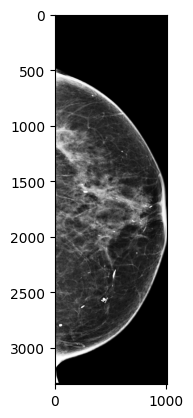

In [5]:
checking_loaded_mamm(processed_mamm)
mammog_name="CALC1"
#mammog_name="InBreast"
#mammog_name="DDSM"
#mammog_name="CardioCare"

## Run the model to detect calcifications









In [ ]:
prediction = predict(model, processed_mamm)
#prediction = core.predict(core.model, mammog)

# Telio: Check and plot prediction mask


Image size: (416, 180)
Image type: float32


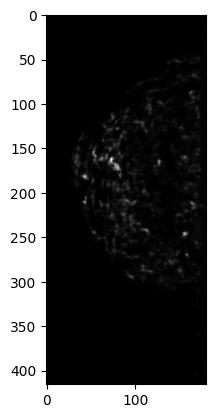

In [ ]:
checking_prediction(prediction)

# Telio: trying various modification for adaptation to algo 2 (HPV)


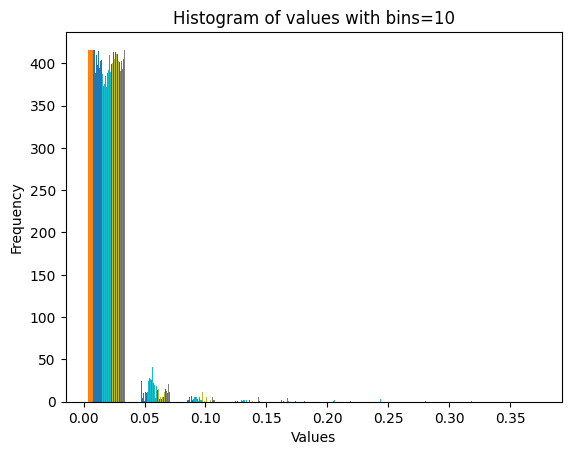

In [ ]:
Histogram_and_choosing_threshold_value(prediction)
threshold_value=0.4

In [ ]:
binary_image=pre_treatment(prediction,threshold_value,fill_holes=True)


# Telio: Check and plot : Modified predict

In [ ]:
checking_prediction(binary_image)

# Telio: Trying other way of simple way of clusterisation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Agglomerative time :0.8444035053253174


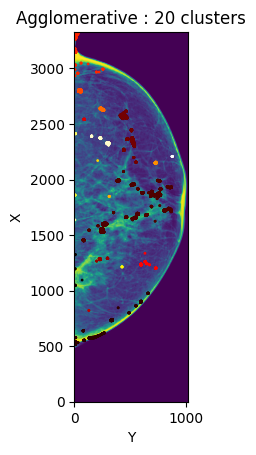

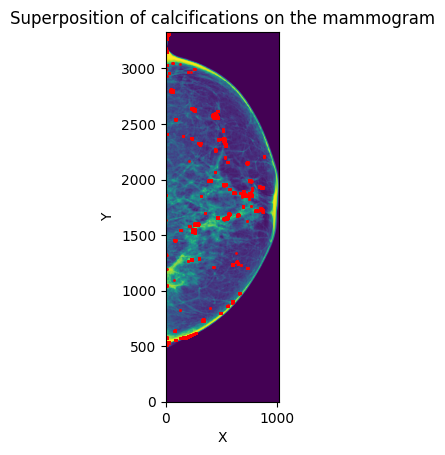

In [ ]:
clustering_choice = AgglomerativeClustering

clustering_labels,regions=Trying_python_clusterisation(clustering_choice,binary_image,n_clusters=5,epsilon=10,min_samples=4)

plotting_different_python_clusterisation(clustering_choice,clustering_labels,regions,processed_mamm,binary_image)



# Telio : Mean of the min


In [ ]:
binary_image=imbin2
clustering_labels=labels_agglo

#AMD  stands for Average Minimal Distance


## MC AMD
def calculate_minimal_distance_for_1_MC(labeled_image, region_label_1):
    # Boolean mask of the targeted MC (1) and the rest of MC
    region_1 = labeled_image == region_label_1
    other_regions = (labeled_image != region_label_1)*(labeled_image>0)

    # Find borders
    boundary_1 = skimage.segmentation.find_boundaries(region_1, mode='inner') #outer for 4 neighboors, inner for 8 neighboors
    other_boundaries = skimage.segmentation.find_boundaries(other_regions, mode='inner')

    # Maps of distance from the boundary of first MC
    distance_map = scipy.ndimage.distance_transform_edt(~boundary_1)
    # Find the minimal distance with the closest MC to boundary_1
    distance_between_boundaries = distance_map[other_boundaries].min()

    return distance_between_boundaries

def calculate_AMD_between_MC(binary_image,print_advance):
    current_time=time.time()
    labeled_image = skimage.measure.label(image)
    numbers_of_MC=np.amax(labeled_image)
    mean_of_min=0
    for label_index in range(0,numbers_of_MC):
        mean_of_min+=calculate_minimal_distance_for_1_MC(labeled_image,label_index+1)
        if time.time()-current_time>10 and print_advance:
          current_time=time.time()
          print('{}% done'.format(label_index*100//numbers_of_MC))
    mean_of_min=mean_of_min/numbers_of_MC
    return mean_of_min

def calculate_AMD_between_MC_of_a_specific_cluster(clustering_labels,binary_image,index_cluster_of_interest):
    mean_of_min_of_specific_cluster=0
    binary_image_of_specific_cluster = np.zeros_like(binary_image) #copy
    for i, label in enumerate(clustering_labels): # set the pixels of the calcifications not belonging to cluster_of_interest to 0
        if label == index_cluster_of_interest:
          y, x = regions[i]
          binary_image_of_specific_cluster[y, x] = 1
    mean_of_min_of_specific_cluster+=calculate_AMD_between_MC(binary_image_of_specific_cluster,False)
    return mean_of_min_of_specific_cluster

def calculate_AMD_between_MC_inside_clusters(clustering_labels,binary_image):
    regions = np.argwhere(binary_image == 1)
    number_of_cluster=max(clustering_labels)+1 #max+1 in fact but cluster index start from 0
    mean_of_min=0
    for index_cluster_of_interest in range(0,number_of_cluster):
        mean_of_min+=calculate_AMD_between_MC_of_a_specific_cluster(clustering_labels,binary_image,index_cluster_of_interest)
        print(f"Cluster done:{index_cluster_of_interest+1}/{number_of_cluster}, (the speed isn't continuous because of the size difference between clusters)")
    return mean_of_min/number_of_cluster



## Clusters AMD
def calculate_minimal_distance_between_2_clusters(binary_image, cluster1_indices, cluster2_indices):
    cluster1_mask = np.isin(binary_image, cluster1_indices)
    cluster2_mask = np.isin(binary_image, cluster2_indices)

    boundary_cluster1 = skimage.segmentation.find_boundaries(cluster1_mask, mode='inner')
    boundary_cluster2 = skimage.segmentation.find_boundaries(cluster2_mask, mode='inner')

    if np.count_nonzero(boundary_cluster1) == 0 or np.count_nonzero(boundary_cluster2) == 0:
        return None  # Skip calculation if one of the clusters has no boundaries

    distance_map_cluster1 = scipy.ndimage.distance_transform_edt(~boundary_cluster1)
    distance_between_boundaries = distance_map_cluster1[boundary_cluster2].min()

    return distance_between_boundaries

def calculate_pairwise_AMD_between_clusters(clustering_labels, binary_image):
    number_of_clusters = max(clustering_labels) + 1
    mean_of_min = 0
    pair_count = 0

    for cluster1_index in range(number_of_clusters):
        for cluster2_index in range(cluster1_index + 1, number_of_clusters):  # Compare different clusters
            cluster1_indices = np.where(clustering_labels == cluster1_index)[0]
            cluster2_indices = np.where(clustering_labels == cluster2_index)[0]
            AMD_between_clusters = calculate_minimal_distance_between_2_clusters(binary_image, cluster1_indices, cluster2_indices)
            if AMD_between_clusters is not None:
                mean_of_min += AMD_between_clusters
                pair_count += 1

    if pair_count > 0:
        mean_of_min /= pair_count  # Calculate the average for all pairs of clusters

    return mean_of_min


## McIN
def count_MC_in_radius_for_a_specific_MC(binary_image, MC_index, radius,label_already_calculated):
    if label_already_calculated:
      labeled_image=binary_image
    else :
      labeled_image=skimage.measure.label(binary_image)
    regions = skimage.measure.regionprops(labeled_image)
    y1, x1 = regions[MC_index - 1].centroid  # index - 1 because indexing start at 1

    count = 0
    for i, region in enumerate(regions):
        if i == MC_index - 1:
            continue  # Ignore the MC itself

        y2, x2 = region.centroid
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if distance <= radius:
            count += 1

    return count

def count_Mc_IN_general(binary_image,radius):
    labeled_image = skimage.measure.label(image)
    numbers_of_MC=np.amax(labeled_image)
    Sum=0
    for MC_index in range(0,numbers_of_MC):
        Sum+=count_MC_in_radius_for_a_specific_MC(labeled_image, MC_index, radius,True)
    return Sum/numbers_of_MC

#AMD_between_MC_inside_clusters = calculate_AMD_between_MC_inside_clusters(clustering_labels,binary_image)
#print("mean_of_min_distance_between_MC_inside_clusters: {}".format(AMD_between_MC_inside_clusters))

#AMD_between_MC = calculate_AMD_between_MC(binary_image,True)
#print("mean_of_min_distance_between_MC: {}".format(AMD_between_MC))


#AMD_between_clusters  = calculate_pairwise_AMD_between_clusters(clustering_labels,binary_image)
#print("mean_of_min_distance_between_clusters_pairwise: {}".format(AMD_between_clusters))

Mc_IN = count_MC_in_radius_for_a_specific_MC(binary_image, MC_index=4, radius=15,label_already_calculated=False)
print("Mc_IN: {}".format(Mc_IN))

Mc_IN_G = count_Mc_IN_general(binary_image, radius=15)
print("Mc_IN_G: {}".format(Mc_IN_G))


Mc_IN: 3
Mc_IN_G: 0.7430555555555556


# Telio : Labeling and quick check


In [ ]:
# Labeling
label_image = labeling(binary_image)

# Plot
checking_everything_until_labels(processed_mamm,prediction,binary_image,label_image)

NameError: ignored

# Telio: Smaller characlist for HPV


 Number of MC kept for their characteristics (not too small): %d  0


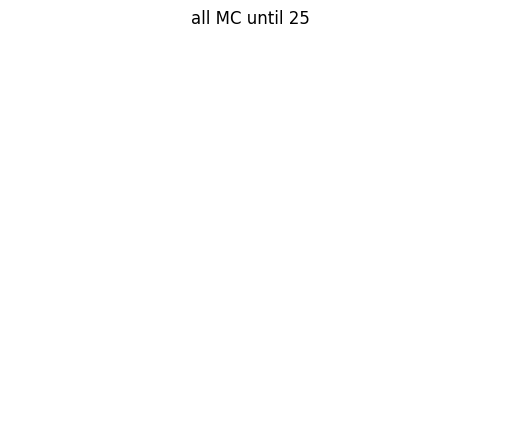

In [ ]:
MC_locations_for_HPV,features_list_for_HPV,features_list=Calculating_characteristics_and_MC_locations_for_HPV(processed_mamm,label_image)
plotting_Mc_treated_for_HPV(processed_mamm,label_image)

#Telio : Making our own list of characteristics for HPV

In [ ]:
class Calc_features :
    "microcalcifications HPV features"
    def __init__(self):
        self.Area = 0
        self.Centroid = 0
        self.MajorAxisLength = 0
        self.MinorAxisLength = 0
        self.Eccentricity = 0
        self.Orientation = 0
        self.EquivDiameter = 0
        self.Solidity = 0
        self.Perimeter = 0
        self.WeightedCentroid = 0 ##
        self.Circularity = 0
        self.EllipticalDeviation = 0
        self.MassDisplacement = 0
        self.IntegratedIntensity= 0
        self.MeanIntensity= 0
        self.IntensityDeviation= 0
        self.IntensityRange= 0

        self.MeanInsideBoundaryIntensity= 0 ##
        self.InsideBoundaryIntensityDeviation = 0 ##
        self.InsideBoundaryIntensityRange = 0 ##
        self.NormalizedInsideBoundaryIntensity = 0 ##

        self.MeanOutsideBoundaryIntensity= 0
        self.OutsideBoundaryIntensityDeviation = 0
        self.OutsideBoundaryIntensityRange = 0
        self.NormalizedOutsideBoundaryIntensity = 0

        self.BoundarySaliency = 0
        self.NormalizedBoundarySaliency = 0

    def print_fea(self):
        print('Area %d' % (self.Area))
        print('Centroid (%.2f %.2f)' % (self.Centroid))
        print('MajorAxisLength %.2f' % (self.MajorAxisLength ))
        print('MinorAxisLength %.2f' % (self.MinorAxisLength ))
        print('Eccentricitcy %.2f' % (self.Eccentricitcy))
        print('Orientation %.2f' % (self.Orientation))
        print('EquivDiameter %.2f' % (self.EquivDiameter))
        print('Solidity %.2f' % (self.Solidity))
        print('Perimeter %.2f' % (self.Perimeter))
        print('WeightedCentroid (%.2f %.2f)' % (self.WeightedCentroid))

        print('Circularity %.2f' % (self.Circularity))
        print('EllipticalDeviation %.2f' % (self.EllipticalDeviation))
        print('MassDisplacement %.2f' % (self.MassDisplacement))

        print('IntegratedIntensity %.2f' % (self.IntegratedIntensity))
        print('MeanIntensity %.2f' % (self.MeanIntensity))
        print('IntensityDeviation %.2f' % (self.IntensityDeviation))
        print('IntensityRange %.2f' % (self.IntensityRange))

    def print_addit_fea(self):
        print("\n")
        print('MeanInsideBoundaryIntensity %.2f' % (self.MeanInsideBoundaryIntensity) )
        print('InsideBoundaryIntensityDeviation %.2f' % (self.InsideBoundaryIntensityDeviation) )
        print('InsideBoundaryIntensityRange %.2f' % (self.InsideBoundaryIntensityRange) )
        print('NormalizedInsideBoundaryIntensity %.2f' % (self.NormalizedInsideBoundaryIntensity) )

        print('MeanOutsideBoundaryIntensity %.2f' % (self.MeanOutsideBoundaryIntensity) )
        print('OutsideBoundaryIntensityDeviation %.2f' % ( self.OutsideBoundaryIntensityDeviation) )
        print('OutsideBoundaryIntensityRange %.2f' % (self.OutsideBoundaryIntensityRange) )
        print('NormalizedOutsideBoundaryIntensity %.2f' % (self.NormalizedOutsideBoundaryIntensity) )

        print('BoundarySaliency %.2f' % (self.BoundarySaliency))
        print('NormalizedBoundarySaliency %.2f' % (self.NormalizedBoundarySaliency))


# Properties determination
# For matlab next step: *255
processed_mamm = processed_mamm*255
props = skimage.measure.regionprops(label_image,processed_mamm)

for region in props:

    #print("\n ==== region label : ", region.label)
    features_long_list = Calc_features()

    # fill attributs directly matlab to python
    features_long_list.Area = region.area
    features_long_list.Centroid = region.centroid
    features_long_list.MajorAxisLength = region.axis_major_length
    features_long_list.MinorAxisLength = region.axis_minor_length
    features_long_list.Eccentricicy = region.eccentricity

    features_long_list.Orientation = region.orientation
    features_long_list.EquivDiameter = region.equivalent_diameter_area
    features_long_list.Solidity = region.solidity
    features_long_list.Perimeter = region.perimeter
    features_long_list.WeightedCentroid = region.centroid_weighted

    # fill attributs light blue
    features_long_list.Circularity =  4 * math.pi * features_long_list.Area / (features_long_list.Perimeter**2)
    features_long_list.MassDisplacement = sqrt(sum((np.array(features_long_list.Centroid) - np.array( features_long_list.WeightedCentroid))**2)) / features_long_list.EquivDiameter

    # fill attributs dark blue
    # we use python if available
    lab = region.label
    regionNG = region.image_intensity
    regionMask = region.image_filled     #region.image
    pixelValues = regionNG * regionMask


    #not computed. Default value ????
    features_long_list.EllipticalDeviation = 0


    features_long_list.IntegratedIntensity= pixelValues.sum()
    features_long_list.MeanIntensity= pixelValues.mean()  #intensity_mean
    features_long_list.IntensityDeviation= pixelValues.std()
    features_long_list.IntensityRange= np.percentile(pixelValues,97.5) - np.percentile(pixelValues,2.5)

    #features_long_list.print_fea()

    # fill attributs violine

    se = skimage.morphology.disk(round(features_long_list.EquivDiameter/8))

    ero = skimage.morphology.binary_erosion(regionMask, footprint =se)
    insideBoundary = regionMask - 1*ero  # to get numerical and not boolean
    insideBoundaryValues = regionNG * insideBoundary;

    list_insideBoundaryValues = insideBoundaryValues[insideBoundary!=0]

    if len(list_insideBoundaryValues) > 0 :
    # inside boundary intensity statistics:
        features_long_list.MeanInsideBoundaryIntensity = list_insideBoundaryValues.mean()
        features_long_list.InsideBoundaryIntensityDeviation = list_insideBoundaryValues.std()
        features_long_list.InsideBoundaryIntensityRange = np.percentile(list_insideBoundaryValues,97.5) - np.percentile(list_insideBoundaryValues,2.5)
        features_long_list.NormalizedInsideBoundaryIntensity = features_long_list.MeanInsideBoundaryIntensity / features_long_list.MeanIntensity

    # outside boundary intensuty statistics:
    #Problems of value, not the best solution yet:
    regionMaskbis = np.copy(label_image)
    regionMaskbis[label_image != region.label] = 0
    regionMaskbis[label_image == region.label] =1
    #plt.figure()
    #plt.imshow(regionMaskbis )
    dil = skimage.morphology.binary_dilation(regionMaskbis, footprint =se)
    outsideBoundary = 1*dil - regionMaskbis

    outsideBoundaryValues = processed_mamm * outsideBoundary
    #plt.figure()
    #plt.imshow(outsideBoundaryValues  )

    # outside boundary intensuty statistics:
    list_outsideBoundaryValues = outsideBoundaryValues[outsideBoundary!=0]

    if len(list_outsideBoundaryValues) > 0 :
        features_long_list.MeanOutsideBoundaryIntensity = list_outsideBoundaryValues.mean()
        features_long_list.OutsideBoundaryIntensityDeviation = list_outsideBoundaryValues.std()
        features_long_list.OutsideBoundaryIntensityRange = np.percentile(list_outsideBoundaryValues, 97.5) - np.percentile(list_outsideBoundaryValues, 2.5)
        features_long_list.NormalizedOutsideBoundaryIntensity = features_long_list.MeanOutsideBoundaryIntensity / features_long_list.MeanIntensity

    features_long_list.BoundarySaliency = features_long_list.MeanInsideBoundaryIntensity - features_long_list.MeanOutsideBoundaryIntensity
    features_long_list.NormalizedBoundarySaliency = features_long_list.NormalizedInsideBoundaryIntensity - features_long_list.NormalizedOutsideBoundaryIntensity

    #features_long_list.print_addit_fea()





<ipython-input-15-5076f551258c>:95: RuntimeWarning: divide by zero encountered in double_scalars
  fea.Circularity =  4 * math.pi * fea.Area / (fea.Perimeter**2)


# Telio : Only for collab+ driver user

In [ ]:
from google.colab import drive

# Google drive mount
drive.mount('/content/drive')


Mounted at /content/drive


 # Telio : new data base load, transform and save

In [ ]:
!pip install pydicom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00


In [ ]:
input_folder = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Inpt/dicoms"
output_folder = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Dicoms"

transforming_Dicoms_to_png(input_folder,output_folder)


Traitement du fichier EE0CA937.dcm
Image sauvegardée : EE0CA937.png
Traitement du fichier EE333477.dcm
Image sauvegardée : EE333477.png
Traitement du fichier EE503A67.dcm
Image sauvegardée : EE503A67.png
Traitement du fichier EE61BA1D.dcm
Image sauvegardée : EE61BA1D.png
Traitement du fichier EE632566.dcm
Image sauvegardée : EE632566.png
Traitement du fichier EEB00A05.dcm
Image sauvegardée : EEB00A05.png
Traitement du fichier EEC96467.dcm
Image sauvegardée : EEC96467.png


# Telio: save features list for HPV

In [ ]:
directory_path_characteristics_for_HPV = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Saved_characteristics "
Saving_characteristics_HPV_format(directory_path_characteristics_for_HPV,mammog_name,MC_locations_for_HPV,features_list_for_HPV,"txt")



# Telio: Save images for algo 2 (HPV)

In [ ]:
directory_path_img = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Saved_Images"

Saving_images_used_and_produced(directory_path_img,mammog_name,processed_mamm,prediction,binary_image,chosen_format="png")

True

## Show results

Use the slide bar to change threshold of the results (it can take about 30 secs to show the updated results)

In [ ]:
foo = partial(show_mamm_w_boxes, processed_mamm, prediction)
#foo = partial(show_mamm_w_boxes, processed_mamm, prediction_modified)
foo.__name__ = "foo"
interact(foo, th=FloatSlider(min=0, max=1, step=.01, value=.5));

interactive(children=(FloatSlider(value=0.5, description='th', max=1.0, step=0.01), Output()), _dom_classes=('…